In [2]:
import landsat_sample_functions as lf

In [3]:
import glob
import os
import re
import datetime
dexpr = re.compile("\d{4}[-/]\d{2}[-/]\d{2}")

In [4]:
rgbf = glob.glob('../data/landast_archibe/RGB_subset_*')
rthermrad = glob.glob('../data/landast_archibe/landsat_thermrad_*')
rflect = glob.glob('../data/landast_archibe/landsat_reflectances_*')
latlon = glob.glob('../data/landast_archibe/landsat_latlon_*')


In [5]:
def unpack(filename):
    _, fullname = os.path.split(filename)
    name, ext = os.path.splitext(fullname)
    date = dexpr.findall(name)[0]
    dt = datetime.datetime.strptime(date, '%Y-%m-%d')
    if ext == '.txt':
        data = lf.landsat_read(filename)
    return (dt, data)

In [7]:
def up(files):
    return [unpack(fn) for fn in sorted(files)]
    

In [8]:
data = dict()
for f, k in [(rthermrad, "thermrad"), (rflect, "reflectances"), (latlon,"latlon")]:
    data[k] = up(f)


In [11]:
import xarray as xr
import numpy as np

In [12]:
dv = [np.stack(zip(*data[k])[-1]) for k in ['thermrad', 'reflectances']]
    

In [13]:
landsat = np.concatenate( [dv[1], dv[0][...,np.newaxis]], axis=-1)

In [14]:
landsat.shape

(21, 815, 921, 6)

In [15]:
layers  = ['NIR', 'Red', 'Green', 'Blue', 'UV', "Thermal Radiances"]

In [16]:
times, latlon = zip(*data['latlon'])

In [17]:
locs = np.stack(latlon)

In [65]:
lats = locs[...,0]
lons = locs[...,1]

In [66]:
lats.shape

(21, 815, 921)

In [73]:
coords = {'lon':(['time','y', 'x'], lons),
          'lat':(['time','y', 'x'], lats) ,
          'time':list(times), 
          'reference_time':times[0]}

In [79]:
data = dict()
for l, d in zip(layers, landsat.transpose([-1,0, 1,2])):
    print(l, d.shape)
    data[l] = (['time','y', 'x'], d[:, ::-1, :])

('NIR', (21, 815, 921))
('Red', (21, 815, 921))
('Green', (21, 815, 921))
('Blue', (21, 815, 921))
('UV', (21, 815, 921))
('Thermal Radiances', (21, 815, 921))


In [80]:
ds = xr.Dataset(data, coords=coords)

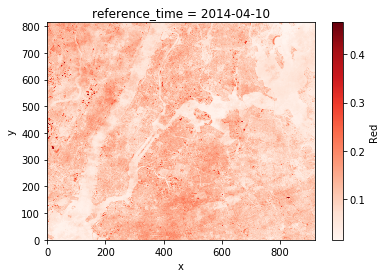

In [81]:
%matplotlib inline
ds['Red'].mean('time').plot(cmap='Reds')

In [85]:
ds.to_netcdf('landsat_hires.nc')